# Question 2: 

### *Does the salesperson impact number and/or value of a sale? If so, can this be correlated to the reporting structure within the company?*

## Define Hypotheses


* ***Null Hypothesis:*** It makes no difference which employee took the order.
* ***Alternate Hypothesis:*** Certain employees generate more (or higher value) sales than others.


For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Data & Libraries

In [22]:
# For SQL & dataframes
import pandas as pd
import sqlite3

# For math & statistics
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


### Make some dataframes from SQL queries

Let's make a few SQL queries to help us get a better idea of what we will be working with. 

First, let's examine the basic aggregate sales stats for each employee.

In [3]:
c.execute("""
          SELECT o.EmployeeId, e.LastName, e.FirstName, e.Title, e.ReportsTo,
          AVG(OrderQuantity) as AvgQuantity, AVG(OrderPrice) as AvgPrice,
          COUNT(Distinct OrderId) as TotalOrders, SUM(OrderQuantity) as TotalQuantity, 
          SUM(OrderPrice) as TotalPrice
          FROM 'Order' o
          JOIN Employee e 
          ON o.EmployeeId = e.Id
          JOIN (SELECT OrderId, SUM(Quantity) as OrderQuantity, 
                SUM(Quantity*UnitPrice*(1-Discount)) as OrderPrice 
                FROM OrderDetail GROUP BY OrderId) od
          ON od.OrderId = o.Id
          GROUP BY o.EmployeeId
          ORDER BY AvgPrice desc;
          """)
employee_agg_sales_df = pd.DataFrame(c.fetchall())
employee_agg_sales_df.columns = [x[0] for x in c.description]
employee_agg_sales_df

,EmployeeId,LastName,FirstName,Title,ReportsTo,AvgQuantity,AvgPrice,TotalOrders,TotalQuantity,TotalPrice
0,9,Dodsworth,Anne,Sales Representative,5.0,62.093023,1797.862012,43,2670,77308.0665
1,2,Fuller,Andrew,"Vice President, Sales",NaN,63.072917,1734.768281,96,6055,166537.7550
2,7,King,Robert,Sales Representative,5.0,64.638889,1730.114375,72,4654,124568.2350
3,5,Buchanan,Steven,Sales Manager,2.0,72.285714,1637.911488,42,3036,68792.2825
4,3,Leverling,Janet,Sales Representative,2.0,61.826772,1596.951520,127,7852,202812.8430
5,1,Davolio,Nancy,Sales Representative,2.0,63.512195,1561.850443,123,7812,192107.6045
6,4,Peacock,Margaret,Sales Representative,2.0,62.807692,1492.890038,156,9798,232890.8460
7,8,Callahan,Laura,Inside Sales Coordinator,2.0,56.855769,1219.829591,104,5913,126862.2775
8,6,Suyama,Michael,Sales Representative,5.0,52.641791,1103.181037,67,3527,73913.1295


It appears that every employee has made more than 30 sales, which is great for conducting statistical tests. 

Now let's create a DataFrame that will serve as our sample population. Once we have this, we can take samples based on employee or reporting structure later on.

In [4]:
c.execute("""
          SELECT o.EmployeeId, e.LastName, e.FirstName, e.Title,
          e.ReportsTo, od.OrderId, od.OrderQuantity, od.OrderPrice
          FROM 'Order' o
          JOIN Employee e 
          ON o.EmployeeId = e.Id
          JOIN (SELECT OrderId, SUM(Quantity) as OrderQuantity, 
                SUM(Quantity*UnitPrice*(1-Discount)) as OrderPrice 
                FROM OrderDetail GROUP BY OrderId) od
          ON od.OrderId = o.Id
          ORDER BY o.EmployeeId asc, od.OrderId asc;
          """)
employee_sales_df = pd.DataFrame(c.fetchall())
employee_sales_df.columns = [x[0] for x in c.description]
display(employee_sales_df.head())
employee_sales_df.info()

,EmployeeId,LastName,FirstName,Title,ReportsTo,OrderId,OrderQuantity,OrderPrice
0,1,Davolio,Nancy,Sales Representative,2.0,10258,121,1614.88
1,1,Davolio,Nancy,Sales Representative,2.0,10270,55,1376.00
2,1,Davolio,Nancy,Sales Representative,2.0,10275,18,291.84
3,1,Davolio,Nancy,Sales Representative,2.0,10285,121,1743.36
4,1,Davolio,Nancy,Sales Representative,2.0,10292,20,1296.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 8 columns):
EmployeeId       830 non-null int64
LastName         830 non-null object
FirstName        830 non-null object
Title            830 non-null object
ReportsTo        734 non-null float64
OrderId          830 non-null int64
OrderQuantity    830 non-null int64
OrderPrice       830 non-null float64
dtypes: float64(2), int64(3), object(3)
memory usage: 52.0+ KB


**Let's take a look at the distribution of Order Prices.**

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


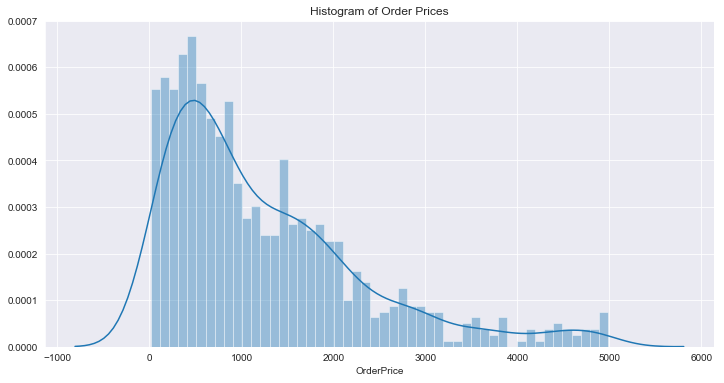

In [5]:
plt.figure(figsize=(12,6))
plt.title('Histogram of Order Prices')
plt.xlabel('Order Price in USD')

# This was run a previous time without the '<5000' portion to identify outliers. 
# Once outliers were identified, the '<5000' was chosen as a cutoff to remove the
# most extreme outliers.
sns.distplot(employee_sales_df.OrderPrice[employee_sales_df.OrderPrice<5000], bins=50);

**Break down by individual employees**

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


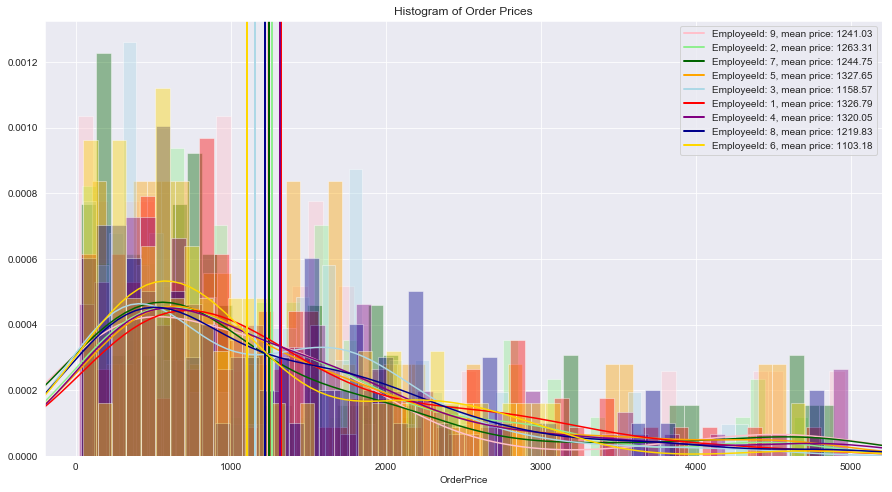

In [6]:
plt.figure(figsize=(15,8))
plt.xlim(-200, 5200)
plt.title('Histogram of Order Prices')
plt.xlabel('Order Price in USD')
colors = ['k','red','lightgreen','lightblue','purple','orange','gold','darkgreen','darkblue','pink']
for employee in list(employee_agg_sales_df.EmployeeId.values):
    sns.distplot(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                              (employee_sales_df.EmployeeId == employee)]
                 , bins=50, color=colors[employee])
    
    mu = np.mean(list(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                              (employee_sales_df.EmployeeId == employee)]))
    plt.axvline(mu, linewidth=2, color=colors[employee],
                label=f'EmployeeId: {employee}, mean price: {round(mu,2)}')
plt.legend()
plt.show();

This cluttered mess is nearly impossible to read any detail, but it does illustrate that the distributions for each employee are similar in general and all of the means are found in the $1100-1330 range.

## Sampling Distributions

To continue, we will need to define a few functions first.

In [7]:
def create_sample_distribution(data, dist_size=1000, n=30):
    """
    Inputs:
    - data : original dataset
    - dist_size : number of samples to generate
    - n : size of each sample
    =======================
    Returns:
    - sample distribution of sample means
    """
    sample_distr = []
    for i in range(0,dist_size):
        sample = []
        i_list = list(np.random.randint(0,len(data),n))
        for item in i_list:
            sample.append(data[item])
        sample_distr.append(np.mean(sample))
    return sample_distr


def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = np.mean(a) - np.mean(b)
    denominator = np.sqrt(np.var(a, ddof=1)/len(a) + np.var(b, ddof=1)/np.size(b))
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (np.var(a, ddof=1)/np.size(a) + np.var(b, ddof=1)/np.size(b))**2
    denom = (((np.var(a, ddof=1)**2) / (((np.size(a))**2) * (np.size(a)-1)))
             + ((np.var(b, ddof=1)**2) / (((np.size(b))**2) * (np.size(b)-1))))
    return num/denom


def p_value(a, b, two_sided=False):
    """
    Returns the p-value from a Welch's t-test given two datasets (lists, arrays, or series).
    """
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p


def Cohen_d(group1, group2):
    """
    group1: Series or NumPy array
    group2: Series or NumPy array
    returns a floating point number 
    """
    diff = np.abs(np.mean(group1) - np.mean(group2))
    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)    
    return d

In [8]:
# # Plot the sampling distributions for every employee
# plt.figure(figsize=(15,8))
# plt.xlim(800, 1900)
# plt.title('Sampling Distributions of Mean Order Prices by Employee')
# plt.xlabel('Order Price in USD')
# colors = ['k','red','lightgreen','lightblue','purple','orange','gold','darkgreen','darkblue','pink']

# emp = []
# ord_pr = []
# ordp = []
# for employee in list(employee_agg_sales_df.EmployeeId.values):
#     for i in range(0,10000):
#         emp.append(employee)
#     a1 = list(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
#                                            (employee_sales_df.EmployeeId == employee)].values)
#     a2 = create_sample_distribution(a1, 10000, 50)
#     ordp.append(a2)
#     sns.distplot(a2, bins=50, color=colors[employee])
#     mu = np.mean(a2)
#     plt.axvline(mu, linewidth=3, color=colors[employee], label=f'Emp.ID {employee} mean = {mu}')

# for i in ordp:
#     for e in i:
#         ord_pr.append(e)

# c1 = list(employee_sales_df.OrderPrice[employee_sales_df.OrderPrice < 5000].values)
# c2 = create_sample_distribution(c1, 10000, 50)
# sns.distplot(c2, bins=50, color='grey')
# c_mu = np.mean(c2)
# plt.axvline(c_mu, linewidth=3, color='grey', label=f'Population mean = {c_mu}')

# plt.legend()
# plt.show();

#### Plotting our sampling distributions against the population sampling distribution


NOTE: mean line colors do not correspond to violin colors


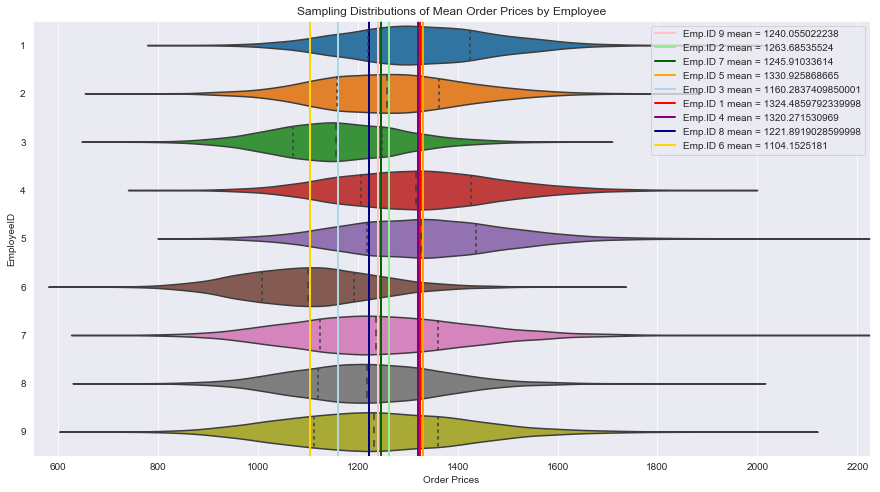

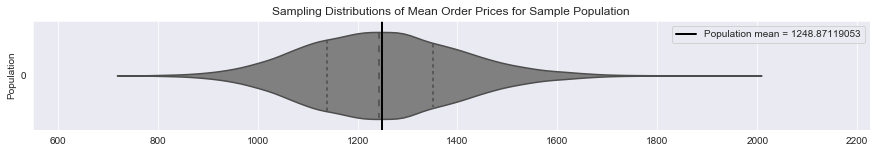

In [9]:
# Plot the sampling distributions for every employee
print('\nNOTE: mean line colors do not correspond to violin colors')
emp = []
ord_pr = []
ordp = []
prices = []

plt.figure(figsize=(15,8))
plt.xlim(550,2225)
for employee in list(employee_agg_sales_df.EmployeeId.values):
    for i in range(0,10000):
        emp.append(employee)
    a1 = list(employee_sales_df.OrderPrice[(employee_sales_df.OrderPrice < 5000) & 
                                           (employee_sales_df.EmployeeId == employee)].values)
    a2 = create_sample_distribution(a1, 10000, 50)
    ordp.append(a2)
    prices += a2
    mu = np.mean(a2)
    plt.axvline(mu, linewidth=2, color=colors[employee], label=f'Emp.ID {employee} mean = {mu}')

# Plotting by employee
distrs = pd.DataFrame()
distrs['EmployeeID'] = emp
distrs['Order Prices'] = prices
plt.title('Sampling Distributions of Mean Order Prices by Employee')
sns.violinplot(x='Order Prices', y='EmployeeID', data=distrs,
               orient='h', inner='quartile', scale='width')
plt.legend();

# Plotting Population
for i in ordp:
    for e in i:
        ord_pr.append(e)
c1 = list(employee_sales_df.OrderPrice[employee_sales_df.OrderPrice < 5000].values)
c2 = create_sample_distribution(c1, 10000, 50)

plt.figure(figsize=(15,2))
plt.xlim(550, 2225)
plt.title('Sampling Distributions of Mean Order Prices for Sample Population')
mu = np.mean(c2)
plt.axvline(mu, linewidth=2, color='k', label=f'Population mean = {mu}')
sns.violinplot(data=c2, color='grey', inner='quartile', orient='h')
plt.ylabel('Population')
plt.legend();

## Hypothesis Testing

In [10]:
# Make a DataFrame of all sampling distributions
samp_distributions = {}
samp_distributions['EmpId'] = emp
samp_distributions['Ord_Pr'] = ord_pr
samp_distributions_df = pd.DataFrame(samp_distributions)

# Run an ANOVA test to see influentiality of salesperson choice
formula = 'Ord_Pr ~ C(EmpId)'
lm = ols(formula, samp_distributions_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq       df            F  PR(>F)
C(EmpId)  4.728541e+08      8.0  2446.684309     0.0
Residual  2.173994e+09  89991.0          NaN     NaN


Interesting, with a p-value of 0.0 from the ANOVA test, we can confidently reject the null hypothesis that the choice of salesperson does not impact the mean price of an order at almost any confidence level (well above the 99.99% threshold). 

### *Can this be correlated to the reporting structure within the company?*

Now that we know that it matters who the salesperson is, let's see if it makes a difference who the salesperson reports to. For this scenario, we are essentially dividing the employees into two teams. 

-One reports to (and includes) the VP -- EmployeeId [1, 2, 3, 4, 8]

-The other reports to (and includes) the sales manager -- EmployeeId [5, 6, 7, 9]

* ***Null Hypothesis:*** Order Price is not affected by which "team" a salesperson belongs to.

* ***Alternative Hypothesis:*** Which "team" a salesperson belongs to has a significant influence on Order Price.

In [11]:
# First, divide our data into two teams

team_2 = []
team_5 = []
for i in employee_sales_df.index:
    if employee_sales_df.OrderPrice[i] < 5000:
        if employee_sales_df.EmployeeId[i] in [5, 6, 7, 9]:
            team_5.append(employee_sales_df.OrderPrice[i])
        else:
            team_2.append(employee_sales_df.OrderPrice[i])

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


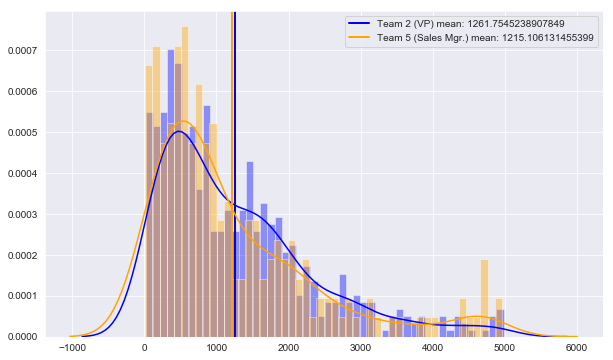

In [12]:
# Plot histograms comparing the two teams

plt.figure(figsize=(10,6))

mu2 = np.mean(team_2)
plt.axvline(mu2, linewidth=2, color='blue', label=f'Team 2 (VP) mean: {mu2}')
sns.distplot(team_2, bins=50, color='blue')

mu5 = np.mean(team_5)
plt.axvline(mu5, linewidth=2, color='orange', label=f'Team 5 (Sales Mgr.) mean: {mu5}')
sns.distplot(team_5, bins=50, color='orange')

plt.legend();

At first glance it seems that the team led by the sales manager typically takes in orders priced $45 higher than the team lead by the VP. Let's run some more tests to make sure this is a reliable finding.

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


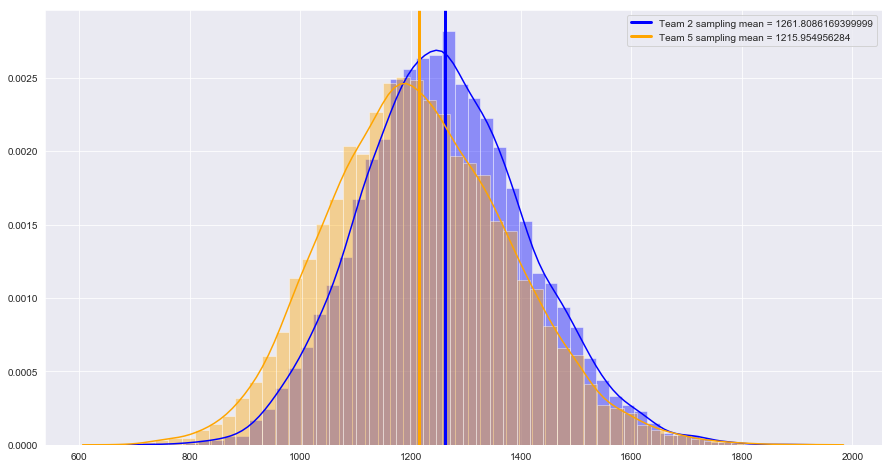

In [13]:
plt.figure(figsize=(15,8))

team_2_samps = create_sample_distribution(team_2, 10000, 50)
sns.distplot(team_2_samps, bins=50, color='blue')
mu2_samps = np.mean(team_2_samps)
plt.axvline(mu2_samps, linewidth=3, color='blue', label=f'Team 2 sampling mean = {mu2_samps}')

team_5_samps = create_sample_distribution(team_5, 10000, 50)
sns.distplot(team_5_samps, bins=50, color='orange')
mu5_samps = np.mean(team_5_samps)
plt.axvline(mu5_samps, linewidth=3, color='orange', label=f'Team 5 sampling mean = {mu5_samps}')

plt.legend();

In [24]:
# Use the Welch's t-test functions defined above to calculate the
# p-value for comparing our two sampling distributions

print("Welch's t-test p-value:\t\t", p_value(team_2_samps, team_5_samps))

Welch's t-test p-value:		 0.0


With a Welch's t-test p-value of 0.0 (or as close to 0 as Python is willing to compute), we can say with practically 100% confidence that our null hypothesis is rejected. Order price is *definitely* correlated to the salesperson's team.

But what is the *effect size* of belonging to one team or the other? Let's calculate *Cohen's d* and see! (...and also find the statistical power as well)

In [28]:
d = Cohen_d(team_2_samps, team_5_samps)
print("Effect size (Cohen's d):", round(d,4))
print("Statistical Power (1-B):", power_analysis.solve_power(effect_size=d, nobs1=len(team_2_samps), alpha=.05))

Effect size (Cohen's d): 0.2912
Statistical Power (1-B): 1.0


A *Cohen's d* score of 0.291 indicates a smallish effect size, though with a power of 1.0, we can safely say that no Type II Errors were committed.

Based on these tests, it appears safe to say that the Sales Manager's team (Team 5) reliably generates higher-valued sales as compared to the VP's team (Team 2). But is this the whole story?

Let's quickly look at the aggregate data again.

In [17]:
employee_agg_sales_df

,EmployeeId,LastName,FirstName,Title,ReportsTo,AvgQuantity,AvgPrice,TotalOrders,TotalQuantity,TotalPrice
0,9,Dodsworth,Anne,Sales Representative,5.0,62.093023,1797.862012,43,2670,77308.0665
1,2,Fuller,Andrew,"Vice President, Sales",NaN,63.072917,1734.768281,96,6055,166537.7550
2,7,King,Robert,Sales Representative,5.0,64.638889,1730.114375,72,4654,124568.2350
3,5,Buchanan,Steven,Sales Manager,2.0,72.285714,1637.911488,42,3036,68792.2825
4,3,Leverling,Janet,Sales Representative,2.0,61.826772,1596.951520,127,7852,202812.8430
5,1,Davolio,Nancy,Sales Representative,2.0,63.512195,1561.850443,123,7812,192107.6045
6,4,Peacock,Margaret,Sales Representative,2.0,62.807692,1492.890038,156,9798,232890.8460
7,8,Callahan,Laura,Inside Sales Coordinator,2.0,56.855769,1219.829591,104,5913,126862.2775
8,6,Suyama,Michael,Sales Representative,5.0,52.641791,1103.181037,67,3527,73913.1295


In [18]:
# split the aggregate data according to team
team2_agg = employee_sales_df.loc[(employee_sales_df.EmployeeId.isin ([1, 2, 3, 4, 8])) 
                                  & (employee_sales_df.OrderPrice <5000)].copy()
team5_agg = employee_sales_df.loc[(employee_sales_df.EmployeeId.isin ([5, 6, 7, 9])) 
                                  & (employee_sales_df.OrderPrice <5000)].copy()

In [29]:
# Calculate the mean number of orders, mean quantities sold, and 
# mean revenue generated per team (with outliers removed)
print('Per-person statistics (outliers removed)\n----------------------------------------')
print(f'Team 2 avg. orders: {len(team2_agg)/5}')
print(f'Team 5 avg. orders: {len(team5_agg)/4}\n')

print(f'Team 2 avg. quantity: {np.sum(team2_agg.OrderQuantity)/5}')
print(f'Team 5 avg. quantity: {np.sum(team5_agg.OrderQuantity)/4}\n')

print(f'Team 2 avg. revenue: {np.sum(team2_agg.OrderPrice)/5}')
print(f'Team 5 avg. revenue: {round(np.sum(team5_agg.OrderPrice)/4,2)}')

Per-person statistics (outliers removed)
----------------------------------------
Team 2 avg. orders: 117.2
Team 5 avg. orders: 53.25

Team 2 avg. quantity: 6834.4
Team 5 avg. quantity: 2982.5

Team 2 avg. revenue: 147877.63019999999
Team 5 avg. revenue: 64704.4


Wow! Despite Team 5 having been shown to reliably generate higher-priced orders, it appears that Team 2 generates more than twice as much revenue! Let's double check things by including the outliers, just in case Team 5 might have a couple of "whales" to tip the scales.

In [30]:
team2_agg_out = employee_agg_sales_df.loc[employee_agg_sales_df.EmployeeId.isin([1, 2, 3, 4, 8])].copy()
team5_agg_out = employee_agg_sales_df.loc[employee_agg_sales_df.EmployeeId.isin([5, 6, 7, 9])].copy()
print('Per-person statistics (outliers included)\n-----------------------------------------')
print(f'Team 2 avg. orders: {np.mean(team2_agg_out.TotalOrders)}')
print(f'Team 5 avg. orders: {np.mean(team5_agg_out.TotalOrders)}\n')
print(f'Team 2 avg. quantity: {np.mean(team2_agg_out.TotalQuantity)}')
print(f'Team 5 avg. quantity: {np.mean(team5_agg_out.TotalQuantity)}\n')
print(f'Team 2 avg. revenue: {np.mean(team2_agg_out.TotalPrice)}')
print(f'Team 5 avg. revenue: {np.mean(team5_agg_out.TotalPrice)}')

Per-person statistics (outliers included)
-----------------------------------------
Team 2 avg. orders: 121.2
Team 5 avg. orders: 56.0

Team 2 avg. quantity: 7486.0
Team 5 avg. quantity: 3471.75

Team 2 avg. revenue: 184242.2652
Team 5 avg. revenue: 86145.42837500002


Nope, things are still pretty much relatively the same. 

## Analysis & Recommendations

Despite our hypothesis testing results concluding that Team 5 regularly generates higher-priced sales than Team 2, it seems that Team 2's strategy is ultimately more beneficial. Rather than focus on increasing the price of each individual order, it appears that Team 2's strategy of focusing on generating the highest number of sales ultimately produces more money for the company. 

Whether or not these are active sales strategies espoused by each team is impossible to determine from the data we have. It may simply be that the best salespeople have been intentionally assigned to the VP's team while the Sales Manager is stuck with less-effective salespeople. 

Whatever the case, moving forward this company should encourage all of its salespeople to focus on producing as many distinct sales as possible and to pay less attention to making the total price of each sale as high as possible; the theory here being that the extra time spent trying to increase the value of a single sale would be better spent generating a second sale to another customer. 